# Securities portfolio modeling. Allocation, optimization and analysis
### Kirill Zakharov
#### telegram: @kirillzx

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as sts
import yfinance as yf
from scipy.optimize import linprog
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import datetime
plt.style.use('ggplot')

In [5]:
class Portfolio:
    def __init__(self, names, dates):
        self.n = len(names)
        self.names = names
        self.data = pd.DataFrame()
        self.new_data = pd.DataFrame()
        self.w = np.array([1/self.n]*self.n)
        self.month_return = 0
        self.month_COV = 0
        self.month_risk = 0
        
    def get_ts(self):
        self.data = pd.DataFrame(columns=self.names)
        for name in self.names:
            self.data[name] = yf.download(name, dates[0], dates[1])['Adj Close']
            
    def get_ts_csv(self):
        self.data = pd.read_csv('quotes.csv', sep='\t', parse_dates=True, index_col='Date')
            
    def graphics(self):
        if self.data.empty:
            print('At first, use get_ts() for download data')
        else:
            fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
            (self.data.pct_change()+1).cumprod().plot(ax=ax)
            plt.show()
            
    def resample_to_months(self):
        self.new_data = self.data.resample('M').last()
    
    def get_month_return(self):
        self.month_return = self.new_data.pct_change().mean()
        return self.month_return
    
    def get_month_COV(self):
        self.month_COV = self.new_data.pct_change().cov()
        return self.month_COV
    
    def get_month_risk(self, w):
        self.month_risk = np.dot(np.dot(w, self.get_month_COV()), w)
        return self.month_risk
    
    def get_returnP(self):
        return np.dot(self.w, self.get_month_return())
    
    def get_returnP_free(self, rf):
        return np.dot(self.w[:self.n], self.get_month_return()) + self.w[self.n] * rf
    
    def get_riskP(self):
        return np.dot(np.dot(self.w, self.get_month_COV()), self.w)
    
    def get_riskP_free(self):
        return np.dot(np.dot(self.w[:self.n], self.get_month_COV()), self.w[:self.n])

In [158]:
class OptimizationP(Portfolio):
    def __init__(self, names, dates):
        super().__init__(names, dates)
        self.bnds = tuple([(0.05, 0.15) for i in range(self.n)])
        self.init = np.repeat(0.05, self.n)
        self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
        self.opt1 = 0
        self.free_cov_matrix = self.get_month_COV()
        self.free_month_return = self.get_month_return()
        
    def get_help(self):
        print('maxReturn - maximize return of the portfolio\nminRisk - minimize risk of the portfolio',\
              '\nmaxSharpe - maximize a Sharpe ratio\nmaxSortino - maximize a Sortino ratio',\
             '\nmaxGenFun - maximize generalized function')    
    
    def optimizeP(self, type_opt, boundsP, initP, rf=0.0037, t=0.5):
        if type_opt == 'maxReturn':
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(lambda x: -np.dot(x, self.get_month_return()), self.init,\
                                 bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'minRisk':
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(lambda x: np.dot(np.dot(x, self.get_month_COV()), x), self.init,\
                                 method='SLSQP', bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
#         elif type_opt == 'maxSharpe':
            
#             self.free_cov_matrix = np.vstack((np.hstack((self.get_month_COV(), np.zeros((self.n,1)))), np.zeros(self.n+1)))
#             self.free_month_return = np.append(self.get_month_return(), rf)
            
#             def sharpe_f(x):
#                 return -(np.dot(self.free_month_return, x) - rf)/np.sqrt(np.dot(np.dot(x, self.free_cov_matrix), x))
            
#             self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n+1)])
#             self.init = np.repeat(initP, self.n+1)
#             self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n+1), x)-1})
            
#             self.opt1 = minimize(sharpe_f, self.init, method='SLSQP', bounds=self.bnds, constraints=self.cons)
#             self.w = self.opt1.x
            
#             return self.opt1
        
        elif type_opt == 'maxSharpe':
            
            def sharpe_f(x):
                return -(np.dot(self.get_month_return(), x) - rf)/np.dot(np.dot(x, self.get_month_COV()), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(sharpe_f, self.init, method='SLSQP', bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'maxSortino':
            r = self.get_month_return()
            array = []
            
            for i in range(len(r)):
                if r[i] < rf:
                    array.append(r[i])
            r2 = 0        
            
            for i in range(len(array)):
                r2 += (array[i] - rf)**2
            
            def sortino_f(x):
                return -(np.dot(self.get_month_return(), x) - rf)/np.sqrt(r2/self.n)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(sortino_f, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'minGenFun':
            
            def genFun(x):
                return -t * np.dot(self.get_month_return(), x) + 0.5 * np.dot(np.dot(x, self.get_month_COV()), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(genFun, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'minGenFunFree':
            
            self.free_cov_matrix = np.vstack((np.hstack((self.get_month_COV(), np.zeros((self.n,1)))), np.zeros(self.n+1)))
            self.free_month_return = np.append(self.get_month_return(), rf)
            
            def genFunFree(x):
                return -t * np.dot(self.free_month_return, x) + 0.5 * np.dot(np.dot(x, self.free_cov_matrix), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n+1)])
            self.init = np.repeat(initP, self.n+1)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n+1), x)-1})
            
            self.opt1 = minimize(genFunFree, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        else:
            return 'Choose the type of optimization. Use Object.get_help() to learn more.'
        
    def multi_criteria_opt(self, boundsP, initP, rf, t):
        f1 = -self.optimizeP('maxReturn', boundsP, initP, rf, t).fun
        f2 = -self.optimizeP('maxSharpe', boundsP, initP, rf, t).fun
        f3 = self.optimizeP('minGenFun', boundsP, initP, rf, t).fun
        
        r1 = np.append(self.get_month_return(), f1)
        r2 = np.append(self.get_month_return(), f2)
        r3 = np.append(self.get_month_return(), f3)
        
        def sharpe_f(x):
                return (np.dot(self.get_month_return(), x) - rf)/np.sqrt(np.dot(np.dot(x, self.get_month_COV()), x))
        
        def genFun(x, t):
                return -t * np.dot(self.get_month_return(), x) + 0.5 * np.dot(np.dot(x, self.get_month_COV()), x)
        
        def fun_x(x):
            array = np.zeros(self.n)
            array = np.append(array, 1)
            return np.dot(array, x)
            
        self.bnds = [(boundsP[0], boundsP[1]) for i in range(self.n)]
        self.bnds.append((0, 1))
        self.bnds = tuple(self.bnds)
        
        self.init = np.repeat(initP, self.n+1)
        self.cons = [{'type':'eq', 'fun': lambda x: np.dot(x[:self.n], np.ones(self.n))-1},
                    {'type':'ineq', 'fun': lambda x: np.array([-f1 + np.dot(x[:self.n], \
                                                                self.get_month_return()) + f1*x[self.n],
                                                              -f2 + sharpe_f(x[:self.n]) + f2*x[self.n]
                                                              -f3 + genFun(x[:self.n], t) + f3*x[self.n]])}]
            
        self.opt1 = minimize(lambda x: x[self.n], self.init, bounds=self.bnds, constraints=self.cons)
        self.w = self.opt1.x[:self.n]
            
        return self.opt1
    
    def optimal_t(self):
        l = np.ones(self.n)
        inv_COV = np.linalg.inv(self.get_month_COV())
        r = self.get_month_return()
        
        h0 = np.dot(l, inv_COV)/np.dot(np.dot(l, inv_COV), l)
        h1 = np.dot(inv_COV, r) - np.dot(inv_COV, l)*np.dot(np.dot(l, inv_COV), r)/np.dot(np.dot(l, inv_COV), l)
        
        alpha0 = np.dot(r, h0)
        alpha1 = np.dot(r, h1)
        beta0 = np.dot(np.dot(h0, self.get_month_COV()), h0)
        
        return (h0, h1, alpha0, alpha1, beta0)
    

In [10]:
names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL', 'IVV']
dates = ('2018-01-01', '2021-02-01')
portfolio1 = Portfolio(names, dates)

In [145]:
portfolio1.get_ts_csv()

In [146]:
portfolio1.data.head(4)

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
Date,,,,,,,,,,
2018-01-03,154.489380,107.051125,197.995163,5095.507324,26.139996,0.638334,127.199066,70.177948,41.373032,255.418671
2018-01-04,159.086075,110.039169,202.738434,5208.654297,26.392916,0.650833,134.899857,71.621933,41.565216,256.524994
2018-01-05,158.952835,111.035172,202.199417,5283.299316,26.435070,0.654023,133.450317,71.621933,42.038452,258.147003
2018-01-09,160.151993,113.367302,203.421158,5185.867676,26.528746,0.654885,136.349426,71.116539,41.877506,259.309631


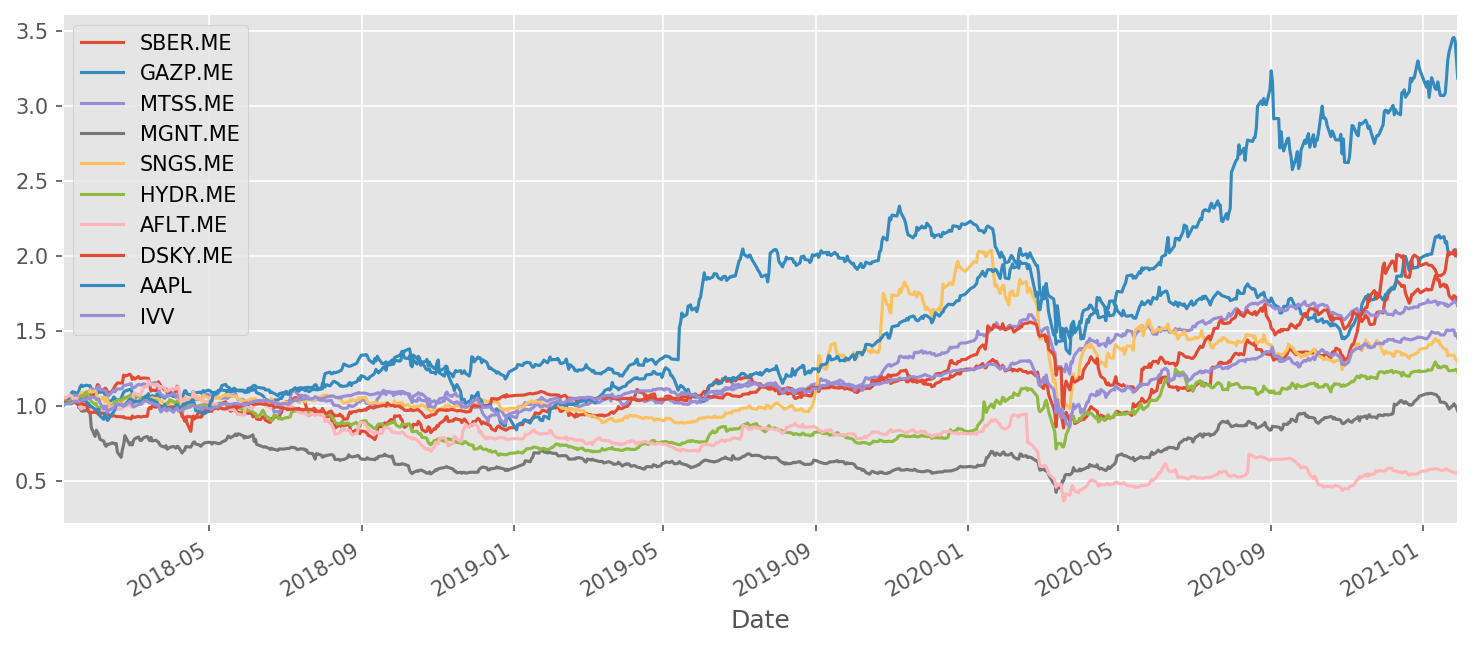

In [147]:
portfolio1.graphics()

In [148]:
portfolio1.resample_to_months()
portfolio1.new_data.head(4)

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
Date,,,,,,,,,,
2018-01-31,176.207153,116.088120,222.070801,4187.981445,26.922180,0.625404,120.766647,66.784569,40.219990,266.416565
2018-02-28,181.470032,115.926170,221.064667,3757.396973,26.898762,0.673677,128.150345,65.340576,42.962379,256.281250
2018-03-31,168.925705,115.254066,211.398468,3677.251709,26.575584,0.663678,140.969910,69.636444,40.468391,249.931442
2018-04-30,151.218384,118.169220,213.015472,3851.685303,27.577906,0.642213,130.460587,67.434357,39.860565,250.816803


In [149]:
portfolio1.get_month_return()

SBER.ME    0.014551
GAZP.ME    0.020665
MTSS.ME    0.012054
MGNT.ME    0.007828
SNGS.ME    0.009364
HYDR.ME    0.008317
AFLT.ME   -0.008443
DSKY.ME    0.024201
AAPL       0.038216
IVV        0.010619
dtype: float64

In [150]:
portfolio1.get_month_COV()

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
SBER.ME,0.008049,0.003786,0.002409,0.002974,0.002677,0.002823,0.005835,0.004609,0.002980,0.003097
GAZP.ME,0.003786,0.007864,0.001618,0.001082,0.003177,0.000605,0.004480,0.002025,0.001375,0.001791
MTSS.ME,0.002409,0.001618,0.002148,0.001639,0.001617,0.001743,0.002390,0.001186,0.002511,0.001611
MGNT.ME,0.002974,0.001082,0.001639,0.007118,0.000584,0.002970,0.002996,0.001977,0.002612,0.001834
SNGS.ME,0.002677,0.003177,0.001617,0.000584,0.007086,0.000244,0.003942,0.001540,0.002735,0.002065
HYDR.ME,0.002823,0.000605,0.001743,0.002970,0.000244,0.004628,0.002658,0.002480,0.002215,0.001416
AFLT.ME,0.005835,0.004480,0.002390,0.002996,0.003942,0.002658,0.012872,0.004946,0.004780,0.004196
DSKY.ME,0.004609,0.002025,0.001186,0.001977,0.001540,0.002480,0.004946,0.006304,0.001859,0.001751
AAPL,0.002980,0.001375,0.002511,0.002612,0.002735,0.002215,0.004780,0.001859,0.009755,0.003825
IVV,0.003097,0.001791,0.001611,0.001834,0.002065,0.001416,0.004196,0.001751,0.003825,0.002931


In [151]:
portfolio1.get_month_risk(portfolio1.w)

0.0029608794043186662

## Portfolio optimization

In [159]:
rf = 0.0037
names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL', 'IVV']
dates = ('2018-01-01', '2021-02-01')
n = len(names)

portfolio_opt = OptimizationP(names, dates)
portfolio_opt.get_help()

maxReturn - maximize return of the portfolio
minRisk - minimize risk of the portfolio 
maxSharpe - maximize a Sharpe ratio
maxSortino - maximize a Sortino ratio 
maxGenFun - maximize generalized function


In [160]:
portfolio_opt.get_ts_csv()

In [161]:
portfolio_opt.resample_to_months()

## Equally allocation

In [10]:
portfolio_opt.w

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [11]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 1.374 %
Risk: 0.296 %


## Maximize return

In [12]:
portfolio_opt.optimizeP('maxReturn', (0.05, 0.15), 0, rf)

     fun: -0.017837188929731348
     jac: array([-0.01455079, -0.02066489, -0.01205357, -0.00782798, -0.00936364,
       -0.00831741,  0.00844261, -0.02420134, -0.03821554, -0.01061899])
 message: 'Optimization terminated successfully.'
    nfev: 180
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([0.15, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.15, 0.15, 0.05])

In [13]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 1.784 %
Risk: 0.306 %


## Maximize Sharpe ratio

In [242]:
portfolio_opt.optimizeP('maxSharpe', (0.05, 0.15), 0.01, rf)

     fun: -4.9921469576467
     jac: array([ 7.96974105,  2.65220988,  2.38106   ,  5.41485947,  4.98539656,
        4.65468168, 19.38571507,  1.32133508, -0.90683746,  4.65780711])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.05      , 0.15      , 0.15      , 0.05      , 0.05      ,
       0.10297852, 0.05      , 0.15      , 0.15      , 0.09702148])

In [243]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 1.732 %
Risk: 0.273 %


## Maximize Sortino ratio

In [15]:
portfolio_opt.optimizeP('maxSortino', (0.05, 0.15), 0, rf)

     fun: -3.681723101716422
     jac: array([-3.78943527, -5.38172051, -3.13908923, -2.03862804, -2.43855742,
       -2.16608855,  2.19869322, -6.30271289, -9.95240435, -2.76548374])
 message: 'Optimization terminated successfully.'
    nfev: 24
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.15, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.15, 0.15, 0.05])

In [16]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 1.784 %
Risk: 0.306 %


## Minimize risk

In [277]:
portfolio_opt.optimizeP('minRisk', (0.05, 0.15), 0, rf)

     fun: 0.00243775764075164
     jac: array([0.00691916, 0.00493763, 0.00360682, 0.00493934, 0.00477811,
       0.00431144, 0.00834874, 0.00498718, 0.00608195, 0.00439994])
 message: 'Optimization terminated successfully.'
    nfev: 192
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.05      , 0.09148027, 0.15      , 0.10356559, 0.12002027,
       0.15      , 0.05      , 0.08493387, 0.05      , 0.15      ])

In [278]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 1.275 %
Risk: 0.244 %


## Minimize generalized function

In [18]:
portfolio_opt.optimizeP('minGenFun', (0.05, 0.15), 0, rf)

     fun: -0.007375518474161059
     jac: array([-0.00331235, -0.00734893, -0.00412534, -0.00163816, -0.00224637,
       -0.00213477,  0.00885891, -0.00917354, -0.01549616, -0.00288219])
 message: 'Optimization terminated successfully.'
    nfev: 168
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([0.11321707, 0.15      , 0.15      , 0.05      , 0.05      ,
       0.05      , 0.05      , 0.15      , 0.15      , 0.08678293])

In [19]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 1.769 %
Risk: 0.294 %


## Minimize generalized function with free risk asset

In [173]:
genfunfree = portfolio_opt.optimizeP('minGenFunFree', (0.05, 0.15), 0, rf)
genfunfree

     fun: -0.0073128024052007455
     jac: array([-0.00354464, -0.00746966, -0.00421837, -0.00174769, -0.00235919,
       -0.00222757,  0.00862347, -0.0093058 , -0.01567421, -0.00303134,
       -0.00185   ])
 message: 'Optimization terminated successfully.'
    nfev: 208
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.0975772, 0.15     , 0.15     , 0.05     , 0.05     , 0.05     ,
       0.05     , 0.15     , 0.15     , 0.0524228, 0.05     ])

In [174]:
print(f'Return: {round(portfolio_opt.get_returnP_free(rf)*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP_free()*100, 3)} %')

Return: 1.729 %
Risk: 0.266 %


## Multi criteria optimization

In [175]:
res1 = portfolio_opt.multi_criteria_opt((0, 1), 0.01, rf, 0.006)
res1

     fun: 0.06748401371748988
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([3.91015320e-16, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.78769303e-17, 1.97446833e-15, 1.84023279e-01,
       8.15976721e-01, 8.10429111e-17, 6.74840137e-02])

In [176]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 3.564 %
Risk: 0.727 %


## Efficient frontier

In [281]:
h0, h1, a0, a1, b0 = portfolio_opt.optimal_t()
a0 = a0*100
a1 = a1*100
b0 = b0*100
a0

1.2180826355960186

In [17]:
t0 = (0.01729 - a0)/a1
t0

-0.031499399760674666

In [80]:
res = portfolio_opt.optimizeP('maxReturn', (0, 1), 0, rf)
res

     fun: -0.03821553555342393
     jac: array([-0.01455079, -0.02066489, -0.01205357, -0.00782798, -0.00936364,
       -0.00831741,  0.00844261, -0.02420134, -0.03821554, -0.01061899])
 message: 'Optimization terminated successfully.'
    nfev: 168
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([6.79751473e-17, 0.00000000e+00, 1.39773331e-16, 5.32111633e-17,
       9.07240184e-17, 0.00000000e+00, 0.00000000e+00, 7.35522754e-16,
       1.00000000e+00, 1.39354730e-18])

In [81]:
[round(i, 3) for i in res.x]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

In [82]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 3.822 %
Risk: 0.976 %


In [268]:
def f(x):
    return np.sqrt(a1*(x - b0)) - 0.05

def sh(x):
    return rf*100 + x*(1.729-rf*100)/0.266

x = np.random.uniform(0, 0.5, 50)

In [269]:
num_portf = 1000
p_r = []
p_std = []
p_w = []
mean_return = portfolio_opt.get_month_return()
COV = portfolio_opt.get_month_COV()

for i in range(num_portf):
    w = np.random.uniform(0, 1, n)
    w = w/np.sum(w)
#     w = np.random.dirichlet(np.ones(n)*100,size=1)[0]
    p_w.append(w)
    
    returns = np.dot(w, mean_return)
    p_r.append(returns*100)
    
    std = np.dot(np.dot(w, COV), w)
    p_std.append(std*100)

In [270]:
array = {'Returns':p_r, 'Risks':p_std}

for i, stock in enumerate(names):
    array[stock] = [w[i] for w in p_w]
    
portfolios = pd.DataFrame(array)    
portfolios.head(4)

,Returns,Risks,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
0,1.559633,0.324426,0.156628,0.079528,0.096388,0.142107,0.142193,0.016745,0.074202,0.057226,0.169409,0.065573
1,1.199393,0.352058,0.089328,0.182876,0.012696,0.066482,0.063979,0.113515,0.179434,0.021422,0.102362,0.167904
2,1.284582,0.287151,0.071641,0.002181,0.165733,0.161541,0.030430,0.124670,0.093573,0.113956,0.097742,0.138533
3,1.587269,0.268962,0.119669,0.142819,0.145815,0.029840,0.018747,0.168670,0.024997,0.165419,0.067544,0.116480


In [271]:
sharpe = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Risks']).idxmax()]
sharpe

Returns    1.765378
Risks      0.241582
SBER.ME    0.001930
GAZP.ME    0.150780
MTSS.ME    0.198183
MGNT.ME    0.054673
SNGS.ME    0.067308
HYDR.ME    0.087082
AFLT.ME    0.014883
DSKY.ME    0.165413
AAPL       0.134172
IVV        0.125577
Name: 593, dtype: float64

In [272]:
def f1(x, r, var):
    return rf + x*(r-rf)/var

def f2(x):
    return -rf/(x-1)

def y(x):
    return -16.7902*x**2 + 23.0453*x - 2.67633

C:\Users\kirill\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


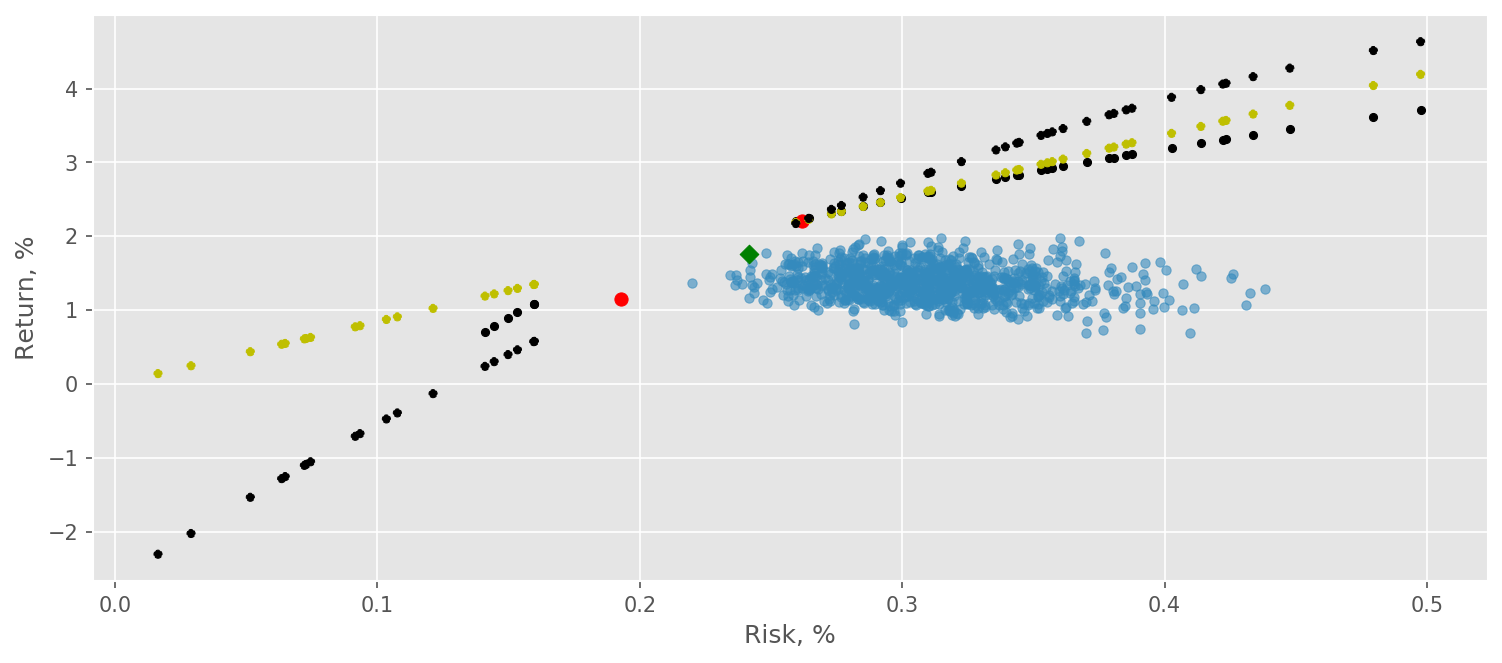

In [274]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
plt.scatter(x, f(x), s=15, c='black')
# plt.plot([0, sharpe['Risks']], [rf*100, sharpe['Returns']])

# plt.scatter(x, f1(x, sharpe['Returns'], sharpe['Risks']), s=10, marker='o', linestyle='--', c='r')
# plt.scatter(b0, a0, c='green', marker='*', s=70)
portfolios.plot.scatter(x='Risks', y='Returns', ax=ax, alpha=0.6)
plt.scatter(sharpe['Risks'], sharpe['Returns'], s=40, c='g', marker='D')

plt.scatter(0.262, 2.209, s=40, c='r') #sharpe ratio (0, 1)
plt.scatter(x, f1(x, 2.209, 0.262), s=15, marker='o', linestyle='--', c='y')

plt.scatter(0.193, 1.146, s=40, c='r') #min-variance (0, 1)

# plt.scatter(0.273, 1.732, s=40, c='r') #sharpe ratio (0.05, 0.15)

plt.scatter(x, y(x), s=15, marker='o', linestyle='--', c='black')
plt.xlabel('Risk, %')
plt.ylabel('Return, %')
plt.show()

# Modeling

In [179]:
#download currency information
curr = yf.download('RUB=X', dates[1], datetime.date.today())['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [185]:
budget = 1000000
rf = 0.0037
names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL', 'IVV']
dates = ('2018-01-01', '2021-02-01')
m = 8 #stocks in currency 1
t = 0.5

In [186]:
class Model:
    def __init__(self, type_opt, names, dates, m, rf, t, curr, budget):
        self.type_opt = type_opt
        self.portfolio = OptimizationP(names, dates)
        self.rf = rf
        self.t = t
        self.costs = []
        self.res = []
        self.m = m
        self.curr = curr
        self.budget = budget
        self.forecast_data = []
        self.names = names
        self.portfolio.get_ts_csv()
        self.portfolio.resample_to_months()
        self.income = []
        
    def simulation(self):
        if self.type_opt == 'multi-criteria':
            self.portfolio.multi_criteria_opt((0.05, 0.15), 0.01, self.rf, self.t)
        else:
            self.portfolio.optimizeP(self.type_opt, (0.05, 0.15), 0, self.rf)
        self.costs = []
        self.res = []
        self.costs = np.array(self.portfolio.data.iloc[-1])

        q = np.dot(self.portfolio.w, self.budget)

        for i in range(self.m):
            self.res.append(q[i] / self.costs[i])

        for i in range(self.m, self.portfolio.n):
            self.res.append(q[i] / (self.curr[-1]*self.costs[i]))

        return self.res
    
    
    def quant(self):
        return f'Quantity: {[round(i) for i in self.simulation()]}'
    
    def forecast(self):
        self.forecast_data = []
        for name in self.names:
            model = ARIMA(self.portfolio.new_data[name], order=(1,2,1), freq='M')
            model_fit = model.fit()
            forecast = model_fit.forecast(5)
            self.forecast_data.append(np.array(forecast))

        self.forecast_data = np.array(self.forecast_data)[:,-1]
        return self.forecast_data
    
    def portfolio_return(self):
        self.income = []
        s = self.simulation()
        self.forecast()
        
        for i in range(self.m):
            self.income.append(self.forecast_data[i]*s[i])

        for i in range(self.m, self.portfolio.n):
            self.income.append(self.forecast_data[i]*self.curr[-1]*s[i])
            
        return sum(self.income) - self.budget   

In [187]:
names_opt = ('maxReturn', 'minRisk', 'maxSharpe', 'maxSortino', 'minGenFun', 'minGenFunFree', 'multi-criteria')
total_return = []

for name in names_opt:
    model = Model(name, names, dates, m, rf, t, curr, budget)
    total_return.append(model.portfolio_return())

In [188]:
for i, name in enumerate(names_opt):
    print(f'{name}: {round(total_return[i], 3)}')
print    

maxReturn: 73468.354
minRisk: 58536.592
maxSharpe: 67094.123
maxSortino: 73468.354
minGenFun: 71063.547
minGenFunFree: 18090.104
multi-criteria: 70362.324


<function print>

In [201]:
model.portfolio_return()

79261.77703955397

In [193]:
model.quant()

'Quantity: [193.0, 702.0, 152.0, 10.0, 1491.0, 64070.0, 715.0, 1753.0, 25.0, 2.0]'